<a href="https://colab.research.google.com/github/Farmhouse121/Adventures-in-Financial-Data-Science/blob/main/Book/Section%202.2.5%20Heteroskedasticity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
print("Installing yfinance and getting the data...")
!pip install yfinance 1>/dev/null
from yfinance import download
import pandas as pd
import numpy as np ;
import matplotlib.pyplot as pl
from statsmodels.base.model import GenericLikelihoodModel
from datetime import datetime
zero,one,two,five,hundred=0e0,1e0,2e0,5e0,1e2 # some friendly numbers
half,GoldenRatio=one/two,(one+np.sqrt(five))/two

# get the daily returns of the S&P 500 
SPX=download('^GSPC','1957-03-01').dropna()
SPX['Return']=SPX['Adj Close'].pct_change()*hundred
SPX.index=pd.DatetimeIndex(SPX.index).to_period('D')
SPX.dropna(inplace=True)
SPX.loc[SPX["Volume"]==0,"Volume"]=np.nan
SPX

Installing yfinance and getting the data...
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,Return
Date,,,,,,,
1957-03-04,44.060001,44.060001,44.060001,44.060001,44.060001,1.890000e+06,0.731595
1957-03-05,44.220001,44.220001,44.220001,44.220001,44.220001,1.860000e+06,0.363141
1957-03-06,44.230000,44.230000,44.230000,44.230000,44.230000,1.840000e+06,0.022610
1957-03-07,44.209999,44.209999,44.209999,44.209999,44.209999,1.830000e+06,-0.045219
1957-03-08,44.070000,44.070000,44.070000,44.070000,44.070000,1.630000e+06,-0.316669
...,...,...,...,...,...,...,...
2022-03-21,4462.399902,4481.750000,4424.299805,4461.180176,4461.180176,3.961050e+09,-0.043466
2022-03-22,4469.100098,4522.000000,4469.100098,4511.609863,4511.609863,3.962880e+09,1.130411
2022-03-23,4493.100098,4501.069824,4455.810059,4456.240234,4456.240234,4.014360e+09,-1.227270


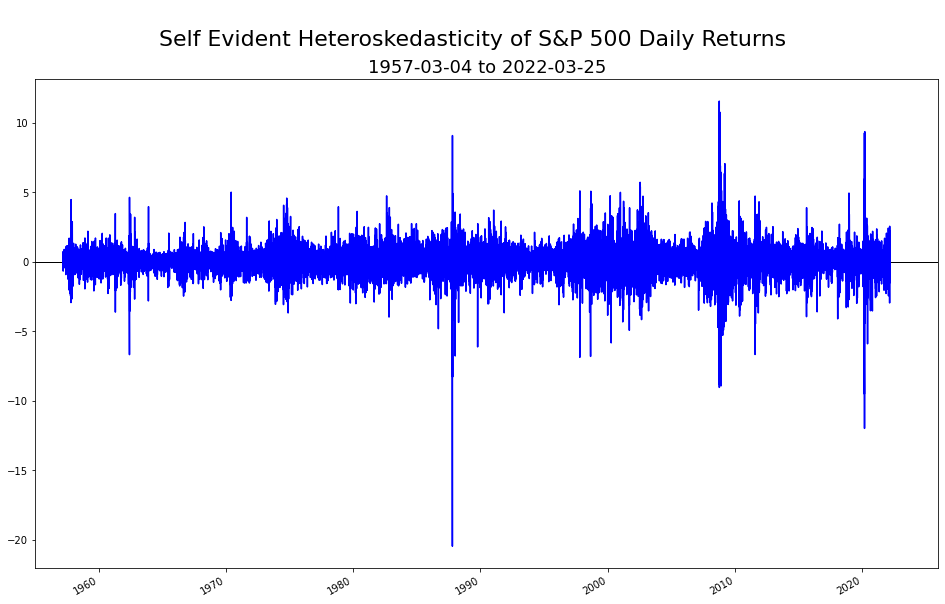

In [14]:
# Figure 2.6
figure,plot=pl.subplots(figsize=(10*GoldenRatio,10))
plot.axhline(color='black',lw=1)
SPX['Return'].plot(ax=plot,color='blue')
figure.suptitle('\nSelf Evident Heteroskedasticity of S&P 500 Daily Returns',fontsize=22)
plot.set_title('%s to %s' % (SPX.index[0],SPX.index[-1]),fontsize=18)
plot.set_xlim(datetime(int(np.floor(SPX.index[0].year/five))*5,1,1),datetime(int(np.ceil(SPX.index[-1].year/five)*5),12,31))
plot.set_xlabel(None);

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.052
Model:                            OLS   Adj. R-squared:                  0.052
Method:                 Least Squares   F-statistic:                     891.6
Date:                Sat, 26 Mar 2022   Prob (F-statistic):          8.38e-191
Time:                        21:33:50   Log-Likelihood:                -48770.
No. Observations:               16379   AIC:                         9.754e+04
Df Residuals:                   16377   BIC:                         9.756e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.7895      0.038     20.809      0.0

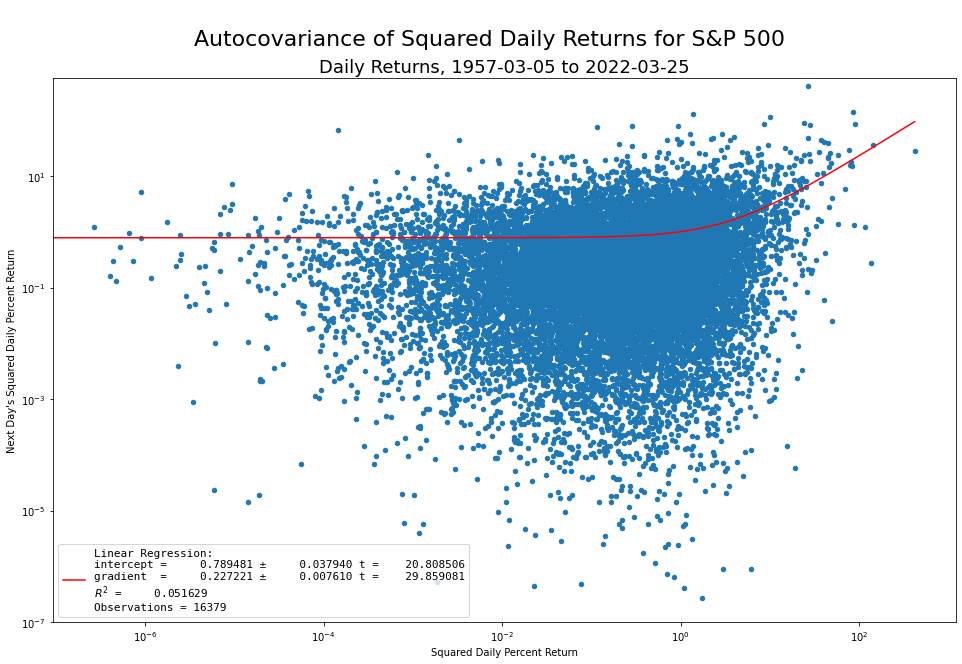

In [49]:
# Linear Regression of r^2(t+1) onto r^2(t)
from statsmodels.formula.api import ols
from statsmodels.sandbox.regression.predstd import wls_prediction_std
df=pd.DataFrame({"y":np.power(SPX["Return"],2),"x":np.power(SPX["Return"].shift(),2)}).dropna()
alpha=0.05 # set alpha_critical to 5%
fit=ols("y ~ x",df).fit() # do OLS regression
df["yhat"]=fit.fittedvalues # get the fitted values
df["sig"],df["crl"],df["cru"]=wls_prediction_std(fit,alpha=alpha) # get the confidence region
df.sort_values(by="x",inplace=True)
print(fit.summary()) # print the regression summary

# Figure 2.6
figure,plot=pl.subplots(figsize=(10*GoldenRatio,10))
df.plot.scatter("x","y",ax=plot)
df.plot.line("x","yhat",ax=plot,label="""Linear Regression:
intercept = %12.6f ± %12.6f t = %12.6f
gradient  = %12.6f ± %12.6f t = %12.6f
$R^2$ = %12.6f
Observations = %d""" % (
    fit.params[0],fit.bse[0],fit.tvalues[0],
    fit.params[1],fit.bse[1],fit.tvalues[1],
    fit.rsquared,
    df.shape[0]),color="red")
plot.set_xscale('log')
plot.set_yscale('log')
plot.set_ylim(1e-7,None)
figure.suptitle("\nAutocovariance of Squared Daily Returns for S&P 500",fontsize=22)
plot.set_title('Daily Returns, %s to %s' % (min(df.index),max(df.index)),fontsize=18)
plot.set_xlabel("Squared Daily Percent Return")
plot.set_ylabel("Next Day's Squared Daily Percent Return")
pl.setp(plot.legend(loc='best',fontsize=11).texts,family='monospace');